<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Caso-de-estudio-1.1.1:-Descifrando-el-genoma-vía-PCA-y-K-Means" data-toc-modified-id="Caso-de-estudio-1.1.1:-Descifrando-el-genoma-vía-PCA-y-K-Means-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Caso de estudio 1.1.1: Descifrando el genoma vía PCA y K-Means</a></span></li><li><span><a href="#Descarga-de-datos" data-toc-modified-id="Descarga-de-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Descarga de datos</a></span></li><li><span><a href="#Generación-de-atributos" data-toc-modified-id="Generación-de-atributos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generación de atributos</a></span></li><li><span><a href="#PCA-(Análisis-de-componentes-principales)" data-toc-modified-id="PCA-(Análisis-de-componentes-principales)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA (Análisis de componentes principales)</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>K-Means</a></span></li><li><span><a href="#Tareas-adicionales:" data-toc-modified-id="Tareas-adicionales:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tareas adicionales:</a></span></li></ul></div>

# Caso de estudio 1.1.1: Descifrando el genoma vía PCA y K-Means

Configuración del notebook:

In [1]:
import requests
import numpy as np
import itertools
import pandas as pd
import re
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Descarga de datos

Tal y como se describe en el guión del Caso de estudio 1.1.1, tanto los datos de la secuenciación genómica del *Caulobacter Crescentus*, como las funciones de MatLab utilizadas por los autores, pueden descargarse en el siguiente [link](http://www.ihes.fr/~zinovyev/pcadg/).

Mediante la librería `requests` podemos acceder a dicha secuenciación y transformarla en una `string` de Python:

In [2]:
url = 'http://www.ihes.fr/~zinovyev/pcadg/ccrescentus.fa'
data = ''.join(requests.get(url).text.split('\r\n')[1:])
print('Longitud de la secuenciación del genoma del Caulobacter Crescentus: {}'.format(len(data)))
print('Primeras 25 letras de la secuenciación: {}'.format(data[:25]))

Longitud de la secuenciación del genoma del Caulobacter Crescentus: 305400
Primeras 25 letras de la secuenciación: gccgatagcctatgatccccggcag


# Generación de atributos

El artículo en el que se basa el Estudio de caso 1.1.1 propone la función de Matlab `CalcFreq` que genera atributos para cada fragmento de 300 letras del genoma. Un parámetro de dicha función es la longitud M (en la función la llama ''len''), de subpalabras en las que se divide cada fragmento (subpalabras de 1,2,3 o letras de longitud). La siguiente función realiza las mismas operaciones:

In [3]:
def CalcFreq(_str,_len,wid):
    '''
    Inputs: 
        _str: la secuenciación completa
        _len: la longitud de las subpalabras (de 1 a 4 letras)
        wid:  la longitud de los fragmentos (en este estudio se 
              usan fragmentos de 300 letras)
    Output:
        xx: matriz de atributos
    '''
    #Cortando la secuenciación en fragmentos 
    fragmentos = [_str[i:i+wid] for i in range(0, len(_str), wid)]
    
    #Generando posibles combinaciones de letras (atributos)
    letras = ['a','c','g','t']
    atributos = [''.join(i) for i in list(itertools.product(letras,repeat=_len))]
    
    #Calculando la frecuencia de cada atributo
    xx = np.zeros((len(fragmentos),len(atributos)))
    for i,frag in enumerate(fragmentos):
        frag = [frag[i:i+_len] for i in range(0, len(frag), _len)]
        for j,atr in enumerate(atributos):
            xx[i,j] = frag.count(atr)
    
    return xx

In [4]:
xx1 = CalcFreq(data,1,300)
xx2 = CalcFreq(data,2,300)
xx3 = CalcFreq(data,3,300)
xx4 = CalcFreq(data,4,300)

# PCA (Análisis de componentes principales)

Una vez hemos obtenido las tablas con los atributos dependiendo de la logitud de las palabras, podemos reducir la dimensionalidad de nuestra información, usando el Análisis de Componentes Principales (PCA). Las siguientes funciones calculan los dos componentes principales mediante la librería `sci-kit learn`, y muestran gráficos de los resultados:

In [5]:
def PCAFreq(xx,_len):
    #Estandardización de los diferentes atributos
    std_xx = StandardScaler().fit_transform(xx)
    #Reducción a dos dimensiones mediante PCA
    pca = PCA(n_components=2)
    comp_principales = pca.fit_transform(std_xx)
    plot_PCA(comp_principales,_len)
    return comp_principales

def plot_PCA(comp_principales,_len):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.scatter(x=comp_principales[:,0],y=comp_principales[:,1],
               marker='.',s=3,color='k',
              )
    ax.annotate(s= 'n = {}'.format(_len),xy=[0.1,0.8],xytext = (0.1,0.8),
                xycoords = 'axes fraction',fontsize=14)
    plt.show()
    

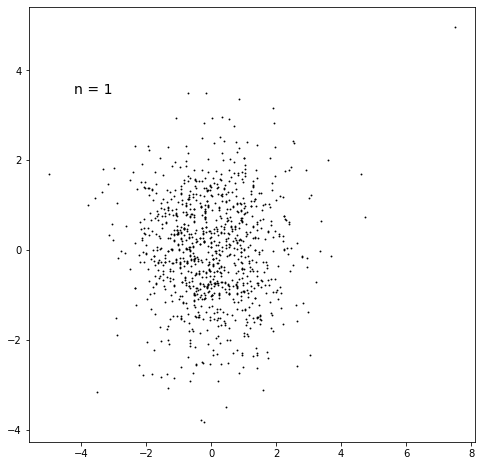

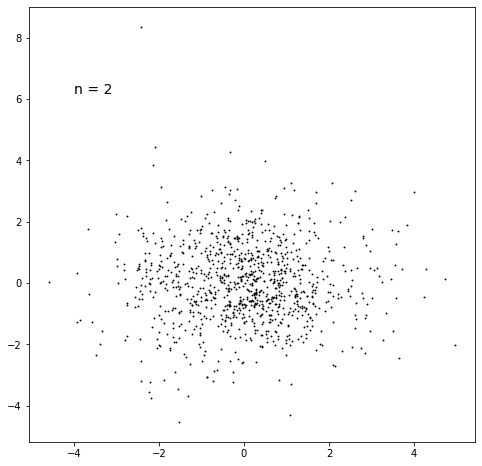

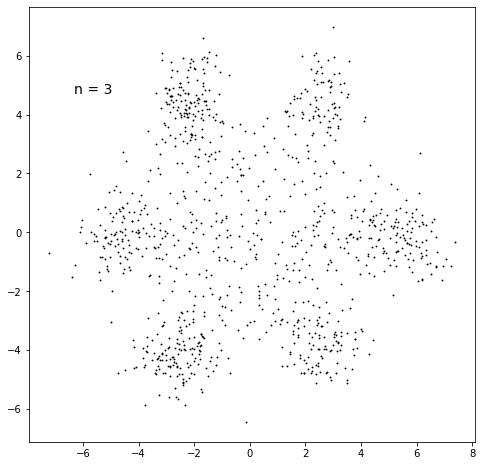

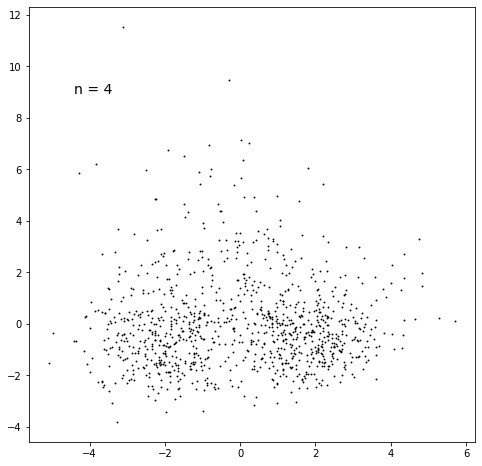

In [6]:
xx1_PCA = PCAFreq(xx1,1)
xx2_PCA = PCAFreq(xx2,2)
xx3_PCA = PCAFreq(xx3,3)
xx4_PCA = PCAFreq(xx4,4)

# K-Means

Por último podemos aplicar K-Means a la tabla generada con palabras de 3 letras. Atención al detalle de que K-Means se aplica a los __64 atributos__ (no a los dos componentes principales obtenidos via PCA), y posteriormente pueden visualizarse los resultados mediante PCA o directamente sobre la secuenciación genética.

In [7]:
def ClustFreq(xx,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(xx)
    clusters = kmeans.labels_
    return clusters

def plot_PCA_colors(xx_PCA,clusters):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    black_cluster = (clusters == 1)
    ax.scatter(x=xx_PCA[black_cluster][:,0],y=xx_PCA[black_cluster][:,1],color='k',
               marker='o',s=10)
    ax.scatter(x=xx_PCA[~black_cluster][:,0],y=xx_PCA[~black_cluster][:,1],
               c=clusters[~black_cluster],cmap='Paired_r',marker='o',s=10)
    plt.show()

def plot_letter_with_colors(data,clusters):
    fragmentos = [data[i:i+300] for i in range(0, len(data), 300)]
    color_map = {0:'grey',2:'red',3:'green',4:'yellow',5:'blue',6:'magenta'}
    for i,frag in enumerate(fragmentos):
        if clusters[i] == 1:
            print(frag)
        else:
            print(colored(frag, color=color_map[clusters[i]]))

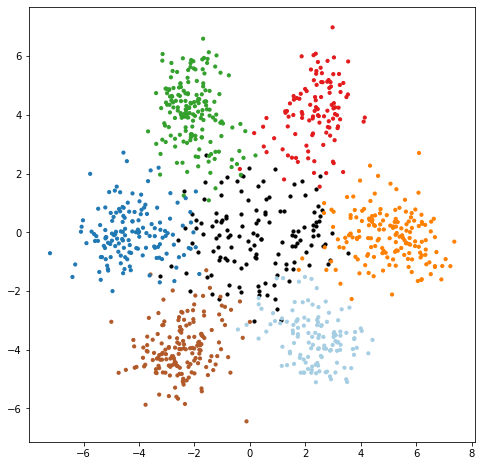

In [10]:
clusters = ClustFreq(xx3,7) 
plot_PCA_colors(xx3_PCA,clusters)

In [12]:
#plot_letter_with_colors(data,clusters)

# Tareas adicionales:

A continuación pueden desarrollarse las diferentes tareas adicionales propuestas en el guión del estudio de caso...